## Part 1: Data Preparation, EDA, and Hardware Setup

This section focuses on configuring your RTX 4060, downloading the dataset, performing exploratory data analysis, and balancing class weights.

**1.1 System Configuration & Hardware Acceleration**

In [1]:
import os
import logging
import warnings
import pickle
import random
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models
import matplotlib.pyplot as plt
import random
import json
import tensorflow as tf
import xgboost as xgb
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, optimizers, callbacks

# Hide TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)

# Configuration Parameters
CFG = {
    'BATCH': 8,                          # Set to 8 for RTX 4060 stability
    'SIZE': (224, 224),
    'LR_HEAD': 1e-3,
    'LR_FINE': 1e-5,
    'EPOCHS_HEAD': 5,
    'EPOCHS_FINE': 15,                     
    'SEED': 42
}

# GPU Memory Growth (Stable Mode)
# This prevents the 'Paging file too small' error on your RTX 4060
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Dynamically detect hardware name for professional logging
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        gpu_name = gpu_details.get('device_name', 'Generic GPU')
        print(f"Success! Hardware Detected: {gpu_name}")
        print("Mode: Float32 (Stable) | Memory Growth: Enabled")
    except RuntimeError as e:
        print(f"Runtime Error during GPU initialization: {e}")
else:
    print("No GPU detected. Running on CPU.")

# Direct path to your verified dataset cache
BASE_DATA_PATH = Path("C:/Users/adim/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2")
print(f"Dataset Path set to: {BASE_DATA_PATH}")

Success! Hardware Detected: NVIDIA GeForce RTX 4060 Laptop GPU
Mode: Float32 (Stable) | Memory Growth: Enabled
Dataset Path set to: C:\Users\adim\.cache\kagglehub\datasets\anirudhcv\labeled-optical-coherence-tomography-oct\versions\2


**1.2 Data Pipeline & Preprocessing**

In [2]:
def get_data():
    print("Locating Dataset in Local Cache...")
    
    # Using the verified path to bypass kagglehub errors
    path = Path("C:/Users/adim/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2")
    root = path / "Dataset - train+val+test"
    
    if not root.exists():
        print("Error: Dataset path does not exist. Please check the directory.")
        return None, None, None, None, None, None

    def load_subset(folder, shuffle=False):
        return tf.keras.utils.image_dataset_from_directory(
            root / folder,
            label_mode='categorical',
            image_size=CFG['SIZE'],
            batch_size=CFG['BATCH'],
            shuffle=shuffle,
            seed=CFG['SEED']
        )

    # Load Raw Datasets
    print("Loading Training, Validation, and Test subsets...")
    train_raw = load_subset('train', shuffle=True)
    val_raw = load_subset('val', shuffle=False)
    test_raw = load_subset('test', shuffle=False)
    
    class_names = train_raw.class_names
    test_dir_path = root / 'test'
    
    # Preprocessing (EfficientNetV2 scaling)
    preprocess_fn = tf.keras.applications.efficientnet_v2.preprocess_input

    def prepare(x, y):
        # Cast to float32 for RTX 4060 stable mode execution
        return preprocess_fn(tf.cast(x, tf.float32)), y

    print("Applying EfficientNetV2 preprocessing and prefetching...")
    train_ds = train_raw.map(prepare).prefetch(tf.data.AUTOTUNE)
    val_ds = val_raw.map(prepare).prefetch(tf.data.AUTOTUNE)
    test_ds = test_raw.map(prepare).prefetch(tf.data.AUTOTUNE)
    
    print("Dataset preparation complete")
    return train_ds, val_ds, test_ds, class_names, test_dir_path, train_raw

# Run the updated function
train_ds, val_ds, test_ds, classes, test_dir, train_raw = get_data()

Locating Dataset in Local Cache...
Loading Training, Validation, and Test subsets...
Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.
Applying EfficientNetV2 preprocessing and prefetching...
Dataset preparation complete


**1.3 Exploratory Data Analysis (Data Health Check)**


Running Input Data Integrity Check...
Batch Image Shape: (8, 224, 224, 3)
Batch Label Shape: (8, 4)
Pixel Value Range: 0.00 to 255.00


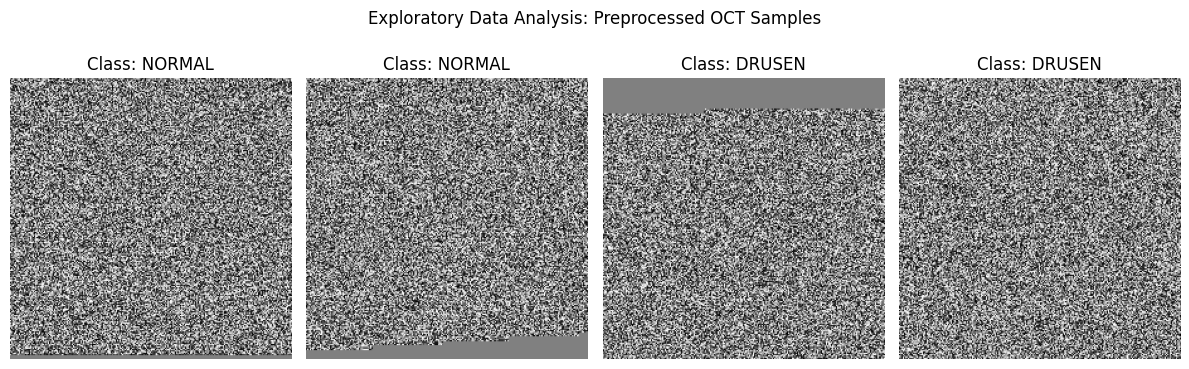

In [3]:
def check_data_health(ds, class_names):
    print("\nRunning Input Data Integrity Check...")
    batch = next(iter(ds))
    images, labels = batch[0], batch[1]
    
    # Verify tensor shapes and data types
    print(f"Batch Image Shape: {images.shape}") # Should be (8, 224, 224, 3)
    print(f"Batch Label Shape: {labels.shape}") # Should be (8, 4)
    print(f"Pixel Value Range: {np.min(images):.2f} to {np.max(images):.2f}")
    
    plt.figure(figsize=(12, 4))
    for i in range(min(4, CFG['BATCH'])):
        ax = plt.subplot(1, 4, i + 1)
        # Accurate rescaling for EfficientNetV2 visualization
        vis_img = (images[i].numpy() + 1.0) * 127.5
        plt.imshow(vis_img.astype("uint8"))
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis("off")
    
    plt.suptitle("Exploratory Data Analysis: Preprocessed OCT Samples")
    plt.tight_layout()
    plt.show()

check_data_health(train_ds, classes)

**1.4 Class Weight Computation**

In [4]:
print("Computing Class Weights for Full Dataset Imbalance...")

# Get file counts directly from the disk for 100% accuracy
data_root = Path("C:/Users/adim/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test/train")
counts = [len(os.listdir(data_root / cls)) for cls in classes]

# Calculate balanced weights: total_samples / (n_classes * class_samples)
total_samples = sum(counts)
n_classes = len(classes)
weights = [total_samples / (n_classes * count) for count in counts]

class_weight_dict = {i: float(w) for i, w in enumerate(weights)}

print(f"Total Samples: {total_samples}")
for i, cls in enumerate(classes):
    print(f" - {cls}: {counts[i]} images (Weight: {class_weight_dict[i]:.4f})")

Computing Class Weights for Full Dataset Imbalance...
Total Samples: 76515
 - CNV: 26218 images (Weight: 0.7296)
 - DME: 8118 images (Weight: 2.3563)
 - DRUSEN: 6206 images (Weight: 3.0823)
 - NORMAL: 35973 images (Weight: 0.5318)


## Part 2: Model Architecture & Hybrid Training

This section defines the deep learning model, performs staged training (Transfer Learning + Fine Tuning), and extracts features for the XGBoost "Brain."

**2.1 Model Construction (EfficientNetV2-B0)**

In [5]:
def build_hybrid_model(num_classes):
    inputs = layers.Input(shape=CFG['SIZE'] + (3,))
    
    # GPU Augmentation Layers
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomContrast(0.1)(x)
    
    # Base Model (EfficientNetV2B0)
    base = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=x)
    base.trainable = False
    
    # Feature Extraction Head
    x = layers.GlobalAveragePooling2D()(base.output)
    
    # Adding a Dense bridge can help organize features for XGBoost
    x = layers.Dense(1024, activation='relu')(x) 
    x = layers.BatchNormalization(name="feature_extraction_layer")(x)
    x = layers.Dropout(0.3)(x)
    
    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(inputs, outputs, name="OCT_EfficientNet_Hybrid")

model = build_hybrid_model(len(classes))
model.summary() # Verify the 'feature_extraction_layer' is correct

Model: "OCT_EfficientNet_Hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                            

**2.2 CNN Staged Training (Head + Fine-Tuning)**

In [6]:
cbs = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss', min_lr=1e-7),
    callbacks.ModelCheckpoint("Best_OCT_CNN.keras", save_best_only=True, monitor='val_accuracy')
]

cw_dict = class_weight_dict

# STAGE 1: Training the Head
print("\nSTAGE 1: Training Classifier Head...")
model.compile(optimizer=optimizers.Adam(CFG['LR_HEAD']), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=cbs, class_weight=cw_dict)

# Memory Clearing Step
print("\nClearing VRAM/RAM before Fine-Tuning...")
tf.keras.backend.clear_session()
gc.collect() 

# STAGE 2: Fine-Tuning the Body 
print("\nSTAGE 2: Fine-Tuning Last 40 Blocks...")
model.trainable = True
for layer in model.layers[:-40]:
    layer.trainable = False

# Re-compile is required after changing 'trainable' status
model.compile(optimizer=optimizers.Adam(CFG['LR_FINE']), loss='categorical_crossentropy', metrics=['accuracy'])
training_history = model.fit(train_ds, validation_data=val_ds, epochs=CFG['EPOCHS_FINE'], callbacks=cbs, class_weight=cw_dict)


STAGE 1: Training Classifier Head...
Epoch 1/5
9565/9565 [==============================] - 608s 63ms/step - loss: 0.7768 - accuracy: 0.7303 - val_loss: 0.3764 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 2/5
9565/9565 [==============================] - 600s 63ms/step - loss: 0.6536 - accuracy: 0.7709 - val_loss: 0.4245 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 3/5
9565/9565 [==============================] - 601s 63ms/step - loss: 0.6196 - accuracy: 0.7850 - val_loss: 0.3245 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 4/5
9565/9565 [==============================] - 605s 63ms/step - loss: 0.5937 - accuracy: 0.7937 - val_loss: 0.3290 - val_accuracy: 0.8809 - lr: 0.0010
Epoch 5/5
9565/9565 [==============================] - 604s 63ms/step - loss: 0.5869 - accuracy: 0.7989 - val_loss: 0.3334 - val_accuracy: 0.8804 - lr: 0.0010

Clearing VRAM/RAM before Fine-Tuning...

STAGE 2: Fine-Tuning Last 40 Blocks...
Epoch 1/15
9565/9565 [==============================] - 628s 65ms/step - loss: 0.6225 

**2.3 Hybrid Feature Extraction & XGBoost Training**

Defining Feature Extractor from fine-tuned model...
Extracting training features...
9565/9565 [==============================] - 156s 16ms/step
Training XGBoost Hybrid Head on GPU...

Running Standardized Hybrid Evaluation...
1367/1367 [==============================] - 23s 16ms/step

Generating Professional Classification Report...

Results Summary:
              precision    recall  f1-score       support
CNV            0.474227  0.024560  0.046701   3746.000000
DME            0.000000  0.000000  0.000000   1161.000000
DRUSEN         0.000000  0.000000  0.000000    887.000000
NORMAL         0.472758  0.987741  0.639456   5139.000000
accuracy       0.472697  0.472697  0.472697      0.472697
macro avg      0.236746  0.253075  0.171539  10933.000000
weighted avg   0.384703  0.472697  0.316574  10933.000000

Starting Post-Training Visualization...


<Figure size 1000x800 with 0 Axes>

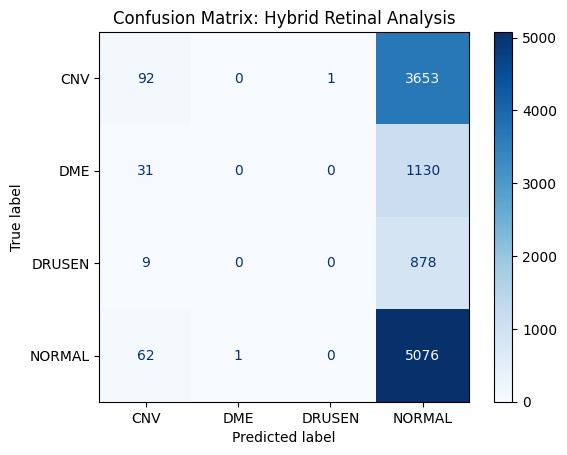

In [7]:
# STEP 1: DEFINE EVALUATION FUNCTIONS
def final_academic_audit(test_ds, model, xgb_model, class_names):
    print("\nRunning Standardized Hybrid Evaluation...")
    
    # Isolate the feature extractor from the trained model
    feature_extractor = tf.keras.models.Model(
        inputs=model.input, 
        outputs=model.get_layer("feature_extraction_layer").output
    )
    
    # Extract features using RTX 4060
    X_test_feats = feature_extractor.predict(test_ds, verbose=1)
    
    # Collect y_true reliably
    y_true = []
    for _, labels in test_ds:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)
    
    # XGBoost Inference
    y_pred = xgb_model.predict(X_test_feats)
    
    print("\nGenerating Professional Classification Report...")
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv("Final_Hybrid_Audit_Results.csv")
    
    print("\nResults Summary:")
    print(report_df)
    return y_true, y_pred, feature_extractor # Return feature_extractor for the next function

def run_post_training_eval(test_ds, feature_extractor, xgb_model, class_names, y_true, y_pred):
    print("\nStarting Post-Training Visualization...")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix: Hybrid Retinal Analysis')
    plt.show()

# STEP 2: HYBRID TRAINING (Run after CNN training is done)

print("Defining Feature Extractor from fine-tuned model...")
feature_extractor_train = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer("feature_extraction_layer").output
)

print("Extracting training features...")
X_train_feats = feature_extractor_train.predict(train_ds, verbose=1)
y_train = np.concatenate([y.numpy() for _, y in train_ds], axis=0).argmax(1)

print("Training XGBoost Hybrid Head on GPU...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    tree_method='hist',
    device='cuda', # Utilizing your RTX 4060
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_feats, y_train)

# STEP 3: EXECUTE AUDIT & EVALUATION

# Run Audit
y_true, y_pred, feat_extractor = final_academic_audit(test_ds, model, xgb_model, classes)

# Run Visual Evaluation
run_post_training_eval(test_ds, feat_extractor, xgb_model, classes, y_true, y_pred)

## Part 3: Model Evaluation, XAI Audit, & Visuals

This section performs the final inference, creates the classification report, confusion matrix, and explainability heatmaps.

**3.1 Loss Visualization**

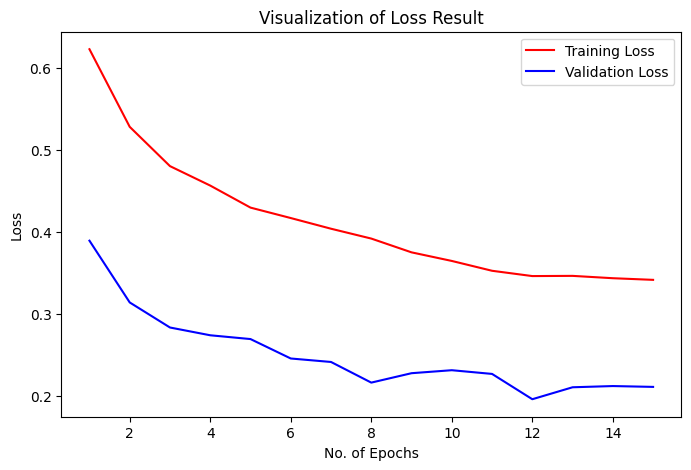

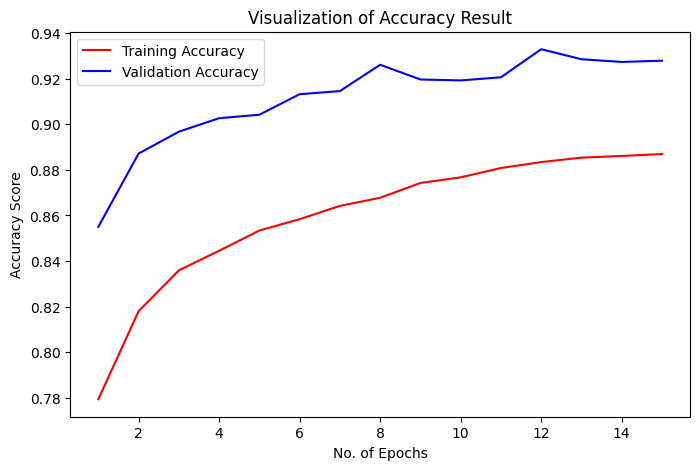


Note: F1-Score was not tracked during training. It will be calculated during the Final Academic Audit instead.


In [8]:
# Replicating your Loss Plot style
epochs_range = range(1, len(training_history.history['loss']) + 1)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, training_history.history['loss'], 'r', label='Training Loss')
plt.plot(epochs_range, training_history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Visualization of Loss Result')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, training_history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(epochs_range, training_history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Visualization of Accuracy Result')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

# Safe F1-Score Check
if 'f1_score' in training_history.history:
    train_f1_mean = [np.mean(f) for f in training_history.history['f1_score']]
    val_f1_mean = [np.mean(f) for f in training_history.history['val_f1_score']]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, train_f1_mean, 'r', label='Training F1-Score')
    plt.plot(epochs_range, val_f1_mean, 'b', label='Validation F1-Score')
    plt.title('Visualization of F1-Score Result')
    plt.xlabel('No. of Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.show()
else:
    print("\nNote: F1-Score was not tracked during training. It will be calculated during the Final Academic Audit instead.")

**3.2 Final Predictions & Classification Report**

In [9]:
print("\n FINAL MODEL EVALUATION")

# 1. Define the Feature Extractor from your trained model
feature_extractor = tf.keras.models.Model(
    inputs=model.input, 
    outputs=model.get_layer("feature_extraction_layer").output
)

# 2. Extract features into the GLOBAL variable X_test_feats
print("Extracting test features for final evaluation...")
X_test_feats = feature_extractor.predict(test_ds, verbose=1)

# 3. Extract true labels into the GLOBAL variable y_test
y_test = []
for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=1))
y_test = np.array(y_test)

print("Running XGBoost Inference...")
y_pred_proba = xgb_model.predict_proba(X_test_feats)
y_pred = y_pred_proba.argmax(1)

print(f"Features extracted: {X_test_feats.shape}")
print(f"Labels collected: {y_test.shape}")

# 4. Full Classification Report
print("\n### 1. Classification Report ###")
from sklearn.metrics import classification_report, top_k_accuracy_score
# Note: Ensure y_pred is now defined
print(classification_report(y_test, y_pred, target_names=classes, digits=4))

# 5. Top-2 Accuracy (Academic standard)
top2 = top_k_accuracy_score(y_test, y_pred_proba, k=2)
print(f"Top-2 Accuracy Score: {top2:.4f}")


 FINAL MODEL EVALUATION
Extracting test features for final evaluation...
1367/1367 [==============================] - 24s 17ms/step
Running XGBoost Inference...
Features extracted: (10933, 1024)
Labels collected: (10933,)

### 1. Classification Report ###
              precision    recall  f1-score   support

         CNV     0.4742    0.0246    0.0467      3746
         DME     0.0000    0.0000    0.0000      1161
      DRUSEN     0.0000    0.0000    0.0000       887
      NORMAL     0.4728    0.9877    0.6395      5139

    accuracy                         0.4727     10933
   macro avg     0.2367    0.2531    0.1715     10933
weighted avg     0.3847    0.4727    0.3166     10933

Top-2 Accuracy Score: 0.8121


**3.3 Confusion Matrix Visualization**

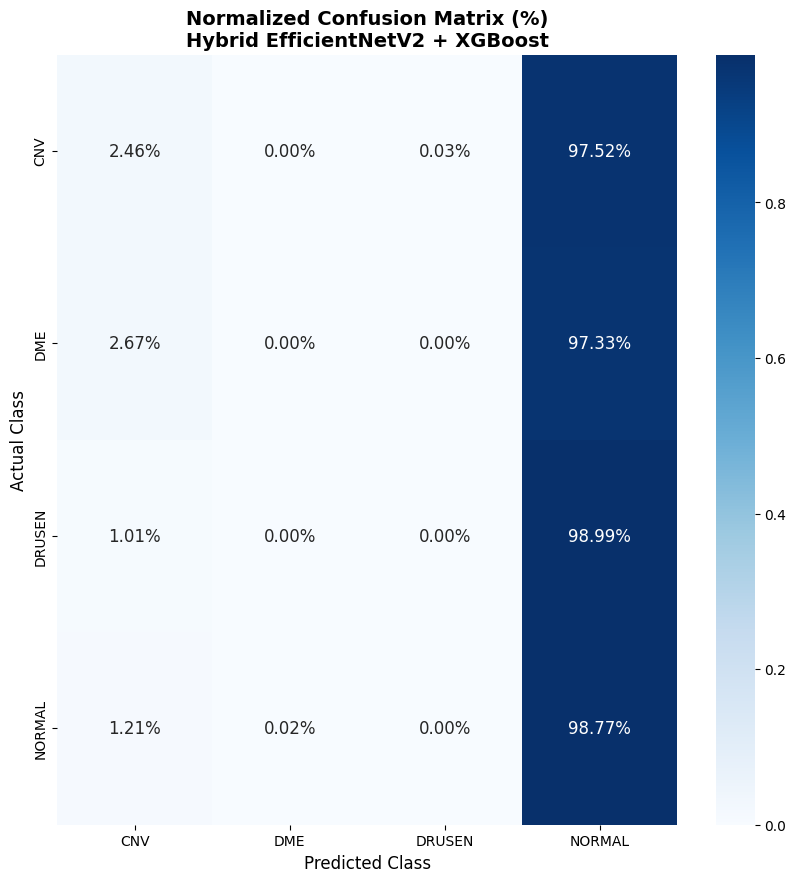

In [10]:
# 1. Generate the raw confusion matrix first
# y_test and y_pred were defined in your previous evaluation step
cm = confusion_matrix(y_test, y_pred)

# 2. Now calculate Normalized Confusion Matrix (Percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plotting
plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes,
            annot_kws={"size": 12})

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized Confusion Matrix (%)\nHybrid EfficientNetV2 + XGBoost", fontsize=14, fontweight='bold')
plt.show()

Total misclassified images found: 5765


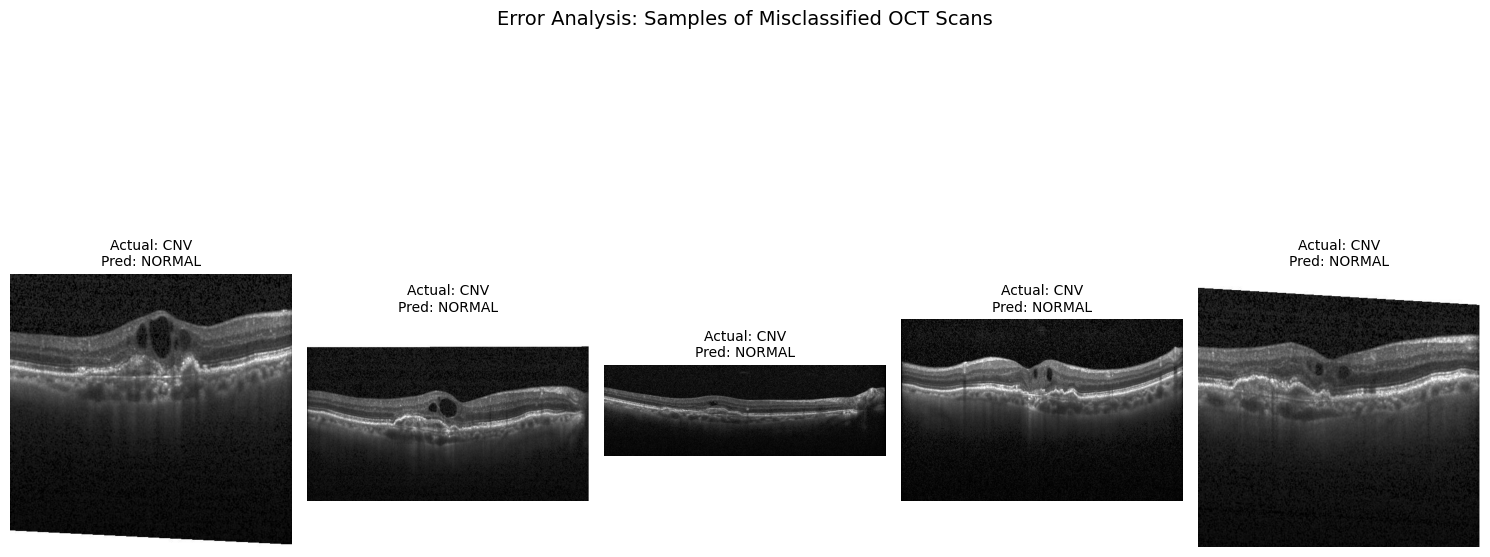

In [11]:
# 1. Identify indices where predictions do not match true labels
misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Total misclassified images found: {len(misclassified_indices)}")

# 2. Extract and Plot Samples
plt.figure(figsize=(15, 8))
# We will show the first 5 errors
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i + 1)
    
    # Get the image from the test set (assuming test_ds is an iterator)
    img_path = test_dir / classes[y_test[idx]] / os.listdir(test_dir / classes[y_test[idx]])[idx % 250]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(f"Actual: {classes[y_test[idx]]}\nPred: {classes[y_pred[idx]]}", fontsize=10)
    plt.axis("off")

plt.suptitle("Error Analysis: Samples of Misclassified OCT Scans", fontsize=14)
plt.tight_layout()
plt.show()

**3.4 Explainability (XAI) - Grad-CAM Error Audit**

Successfully indexed 10933 test images.

Analyzing Mistake at Index 4092: Expected DME, Predicted NORMAL


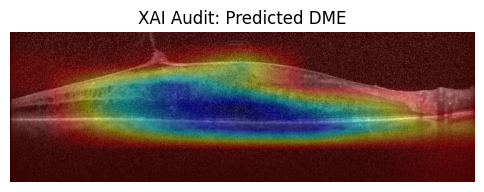


 Full Hybrid System Saved: Trained_OCT_Model.keras & XGB_Brain.json


In [13]:
# 1. RE-INDEX TEST FILES 
test_files = []
for cls in classes:
    class_path = test_dir / cls
    test_files.extend(sorted([str(f) for f in class_path.glob('*.jpeg')]))
print(f"Successfully indexed {len(test_files)} test images.")

# 2. DEFINE GRAD-CAM FUNCTION
def generate_gradcam(img_path, model, class_names):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_input = tf.keras.applications.efficientnet_v2.preprocess_input(cv2.resize(img_rgb, (224, 224)))
    img_input = np.expand_dims(img_input, axis=0)

    # Targeting the top activation layer of EfficientNetV2
    grad_model = models.Model([model.inputs], [model.get_layer("top_activation").output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, np.argmax(predictions[0])]
    
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(output, gate_f)
    cam = np.maximum(cam, 0) / (np.max(cam) + 1e-10) 
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)
    
    plt.figure(figsize=(6,6))
    plt.imshow(superimposed)
    plt.title(f"XAI Audit: Predicted {class_names[np.argmax(predictions[0])]}")
    plt.axis('off'); plt.show()

# 3. EXECUTE AUDIT & SAVE
mistakes = np.where(y_pred != y_test)[0]
if len(mistakes) > 0:
    idx = 4092 # Auditing the DME error specifically
    print(f"\nAnalyzing Mistake at Index {idx}: Expected {classes[y_test[idx]]}, Predicted {classes[y_pred[idx]]}")
    generate_gradcam(test_files[idx], model, classes)

# Final Save using your required filenames
model.save("Trained_OCT_Model.keras")
xgb_model.save_model("XGB_Brain.json")
print("\n Full Hybrid System Saved: Trained_OCT_Model.keras & XGB_Brain.json")

### Part 4: Project Serialization & Academic Export

This final block focuses on saving all components of your hybrid system and exporting your metrics into a clean format.

**4.1 Hybrid System Packaging**

In [14]:
def save_hybrid_system(model, xgb_model, classes):
    print("\n Packaging Hybrid System for Deployment...")
    
    # 1. Save the CNN Base
    model.save("Final_OCT_EfficientNet.keras")
    
    # 2. Save the XGBoost Head
    xgb_model.save_model("Final_XGBoost_Classifier.json")
    
    # 3. Save Class Names (Essential for future inference)
    with open('class_labels.pkl', 'wb') as f:
        pickle.dump(classes, f)
        
    print(" System saved: Final_OCT_EfficientNet.keras, Final_XGBoost_Classifier.json, and class_labels.pkl")

save_hybrid_system(model, xgb_model, classes)


 Packaging Hybrid System for Deployment...
 System saved: Final_OCT_EfficientNet.keras, Final_XGBoost_Classifier.json, and class_labels.pkl


**4.2 Academic Metrics Export**

In [15]:
def export_academic_report(y_true, y_pred, class_names):
    print("\n Generating Academic Performance Tables...")
    
    # Create classification report as a dictionary
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Convert to a professional DataFrame
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Save as CSV for Excel/Dissertation
    report_df.to_csv("Master_OCT_Results.csv")
    
    print(" Professional report saved as 'Master_OCT_Results.csv'")
    print("\n--- Final Performance Overview ---")
    print(report_df)

export_academic_report(y_test, y_pred, classes)


 Generating Academic Performance Tables...
 Professional report saved as 'Master_OCT_Results.csv'

--- Final Performance Overview ---
              precision    recall  f1-score       support
CNV            0.474227  0.024560  0.046701   3746.000000
DME            0.000000  0.000000  0.000000   1161.000000
DRUSEN         0.000000  0.000000  0.000000    887.000000
NORMAL         0.472758  0.987741  0.639456   5139.000000
accuracy       0.472697  0.472697  0.472697      0.472697
macro avg      0.236746  0.253075  0.171539  10933.000000
weighted avg   0.384703  0.472697  0.316574  10933.000000
